# Movie Creation Analysis

Authors: Matt Silver, Brian Woo

## Overview

## Business Problem

### Souces of Data

- Box Office Mojo
- IMDB
- Rotten Tomatoes
- TheMovieDB
- The Numbers

## Extracting datasets

In [2730]:
# imports for extracting data
import os
import gzip
import shutil
import zipfile

# imports for data manipulation
import sqlite3
import pandas as pd
import numpy as np

# import for data visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2731]:
# extracting gz file to a folder called extractedData
source_directory = 'zippedData'
destination_directory = 'extractedData'

# Ensure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# List all .gz files in the source directory
gz_files = [f for f in os.listdir(source_directory) if f.endswith('.gz')]

# Loop through each .gz file and extract it
for gz_file in gz_files:
    gz_file_path = os.path.join(source_directory, gz_file)
    decompressed_file_path = os.path.join(destination_directory, os.path.splitext(gz_file)[0])

    # Open the .gz file and write the decompressed data to the destination directory
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(decompressed_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [2732]:
# extracting the zip file to a folder called extractedData
extract_to_directory = 'extractedData'  

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile('zippedData/im.db.zip'  , 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

## Understanding the Data

In [2733]:
# reading the csv files into dataframes
box_office_mojo_df = pd.read_csv('extractedData/bom.movie_gross.csv')
movie_db_df = pd.read_csv('extractedData/tmdb.movies.csv')
numbers_df = pd.read_csv('extractedData/tn.movie_budgets.csv')

# reading the tsv files into dataframes
rotten_tomatoes_df = pd.read_csv('extractedData/rt.movie_info.tsv', delimiter='\t')
rotten_tomatoes_reviews_df = pd.read_csv('extractedData/rt.reviews.tsv', delimiter='\t', encoding='latin1')

# reading the db file into a dataframe
conn = sqlite3.connect('extractedData/im.db')
imdb_columns_df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """, conn)

# join the movie_ratings, movie_basics, and movie_akas tables
imdb_movies_df = pd.read_sql(
    """
    SELECT basics.primary_title, basics.start_year, basics.runtime_minutes, rating.averagerating as average_rating, rating.numvotes as num_votes, basics.genres
    FROM movie_ratings as rating
    JOIN movie_basics as basics
    USING (movie_id)
    JOIN movie_akas as akas
    USING (movie_id)
    WHERE basics.start_year >= 2014 AND akas.region = 'US'
    """, conn)

# join the principals and persons tables
imdb_people_df = pd.read_sql(
    """
    SELECT persons.primary_name, persons.birth_year, persons.death_year, principals.category, persons.primary_profession
    FROM principals
    JOIN persons
    USING (person_id)
    """, conn)

# close the connection
conn.close()

KeyboardInterrupt: 

In [ ]:
box_office_mojo_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [ ]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [ ]:
box_office_mojo_df.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [ ]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [ ]:
movie_db_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [ ]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [ ]:
movie_db_df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [ ]:
movie_db_df.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [ ]:
numbers_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [ ]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [ ]:
numbers_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [ ]:
numbers_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [ ]:
rotten_tomatoes_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [ ]:
rotten_tomatoes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [ ]:
rotten_tomatoes_df.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [ ]:
rotten_tomatoes_df.describe()

,id
count,1560.000000
mean,1007.303846
std,579.164527
min,1.000000
25%,504.750000
50%,1007.500000
75%,1503.250000
max,2000.000000


In [ ]:
rotten_tomatoes_reviews_df

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [ ]:
rotten_tomatoes_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [ ]:
rotten_tomatoes_reviews_df.isna().sum()

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

In [ ]:
rotten_tomatoes_reviews_df.describe()

,id,top_critic
count,54432.000000,54432.000000
mean,1045.706882,0.240594
std,586.657046,0.427448
min,3.000000,0.000000
25%,542.000000,0.000000
50%,1083.000000,0.000000
75%,1541.000000,0.000000
max,2000.000000,1.000000


In [ ]:
imdb_columns_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [ ]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
1,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
16610,Girl/Girl Scene,2019,122.0,2.1,112,"Comedy,Drama,Romance"
16611,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
16612,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
16613,Hail Satan?,2019,95.0,6.8,628,Documentary


In [ ]:
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16615 entries, 0 to 16614
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    16615 non-null  object 
 1   start_year       16615 non-null  int64  
 2   runtime_minutes  15374 non-null  float64
 3   average_rating   16615 non-null  float64
 4   num_votes        16615 non-null  int64  
 5   genres           16570 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 779.0+ KB


In [ ]:
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    1241
average_rating        0
num_votes             0
genres               45
dtype: int64

In [ ]:
imdb_movies_df.describe()

,start_year,runtime_minutes,average_rating,num_votes
count,16615.000000,15374.000000,16615.000000,1.661500e+04
mean,2015.992296,92.306622,6.211309,1.149874e+04
std,1.483244,22.122593,1.601951,5.996835e+04
min,2014.000000,3.000000,1.000000,5.000000e+00
25%,2015.000000,82.000000,5.100000,1.800000e+01
50%,2016.000000,90.000000,6.300000,8.800000e+01
75%,2017.000000,100.000000,7.400000,7.655000e+02
max,2019.000000,724.000000,10.000000,1.299334e+06


In [ ]:
imdb_people_df

,primary_name,birth_year,death_year,category,primary_profession
0,Tommy Dysart,NaN,NaN,actor,actor
1,Frank Howson,1952.0,NaN,director,"actor,writer,producer"
2,Barry Porter-Robinson,NaN,NaN,producer,"producer,art_department"
3,Sean Barton,1944.0,NaN,editor,"editor,editorial_department,assistant_director"
4,Brittania Nicol,NaN,NaN,actress,"actress,soundtrack"
...,...,...,...,...,...
1027907,Kenneth Cranham,1944.0,NaN,actor,"actor,soundtrack"
1027908,Pearl Mackie,1987.0,NaN,self,actress
1027909,Guy Jones,NaN,NaN,director,director
1027910,Sabrina Mahfouz,NaN,NaN,writer,writer


In [ ]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027912 entries, 0 to 1027911
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   primary_name        1027912 non-null  object 
 1   birth_year          234048 non-null   float64
 2   death_year          11843 non-null    float64
 3   category            1027912 non-null  object 
 4   primary_profession  974266 non-null   object 
dtypes: float64(2), object(3)
memory usage: 39.2+ MB


In [ ]:
imdb_people_df.isna().sum()

primary_name                0
birth_year             793864
death_year            1016069
category                    0
primary_profession      53646
dtype: int64

In [ ]:
imdb_people_df.describe()

,birth_year,death_year
count,234048.000000,11843.00000
mean,1967.742617,1995.25247
std,22.099106,64.57055
min,1.000000,17.00000
25%,1959.000000,2004.00000
50%,1971.000000,2014.00000
75%,1980.000000,2017.00000
max,2014.000000,2019.00000


## Data Cleaning

### Box Office Mojo Clean

In [ ]:
# retrieving title, domestic_gross, and year columns
box_office_mojo_df = box_office_mojo_df[['title', 'studio', 'domestic_gross', 'year']]

# get the rows with year >= 2014
box_office_mojo_df = box_office_mojo_df[box_office_mojo_df['year'] >= 2014]

# resets the index
box_office_mojo_df.reset_index(drop=True, inplace=True)

# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1910 non-null   object 
 1   studio          1908 non-null   object 
 2   domestic_gross  1901 non-null   float64
 3   year            1910 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 59.8+ KB


In [ ]:
# drops rows with missing values in the studio column
box_office_mojo_df.dropna(subset=['studio'], inplace=True)

In [ ]:
# find the duplicates
box_office_mojo_df[box_office_mojo_df.duplicated()]

,title,studio,domestic_gross,year


In [ ]:
# find unknown values in all columns
columns = ['title', 'studio', 'domestic_gross', 'year']
for column in columns:
    print(f'Unknown values in {column}: {len(box_office_mojo_df[box_office_mojo_df[column] == "Unknown"])}')

Unknown values in title: 0
Unknown values in studio: 0
Unknown values in domestic_gross: 0
Unknown values in year: 0


In [ ]:
# find the rows with missing values
box_office_mojo_missing_data = box_office_mojo_df[box_office_mojo_df.isna().any(axis=1)]
box_office_mojo_missing_data

,title,studio,domestic_gross,year
182,Jessabelle,LGF,NaN,2014
204,14 Blades,RTWC,NaN,2014
208,Jack and the Cuckoo-Clock Heart,Shout!,NaN,2014
262,Lila Lila,Crnth,NaN,2014
498,Surprise - Journey To The West,AR,NaN,2015
915,Finding Mr. Right 2,CL,NaN,2016
991,Solace,LGP,NaN,2016
1118,Viral,W/Dim.,NaN,2016


In [ ]:
# fill the NaN values in the domestic_gross column with the median value based on the studio and the year
box_office_mojo_df['domestic_gross'] = box_office_mojo_df.groupby(['studio', 'year'])['domestic_gross'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# create a dictionary of studios and years
studio_year_dict = dict(zip(box_office_mojo_missing_data['studio'], box_office_mojo_missing_data['year']))

# find all rows with studio lgf and year 2014
for studio, year in studio_year_dict.items():
    subset_df = box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)]
    median_values = subset_df.median(numeric_only=True)
    print(f"Median values for studio '{studio}' in year {year}:\n{median_values}\n")

Median values for studio 'LGF' in year 2014:
domestic_gross    16700000.0
year                  2014.0
dtype: float64

Median values for studio 'RTWC' in year 2014:
domestic_gross    1006500.0
year                 2014.0
dtype: float64

Median values for studio 'Shout!' in year 2014:
domestic_gross    2800.0
year              2014.0
dtype: float64

Median values for studio 'Crnth' in year 2014:
domestic_gross    11300.0
year               2014.0
dtype: float64

Median values for studio 'AR' in year 2015:
domestic_gross       NaN
year              2015.0
dtype: float64

Median values for studio 'CL' in year 2016:
domestic_gross    92400.0
year               2016.0
dtype: float64

Median values for studio 'LGP' in year 2016:
domestic_gross       NaN
year              2016.0
dtype: float64

Median values for studio 'W/Dim.' in year 2016:
domestic_gross    55000.0
year               2016.0
dtype: float64



In [ ]:
# find the number of movies AR studio released in each year
box_office_mojo_df[box_office_mojo_df['studio'] == 'AR'].value_counts('year')

year
2016    1
2015    1
dtype: int64

In [ ]:
# drop the row with studio AR and year 2015
box_office_mojo_df.drop(box_office_mojo_df[(box_office_mojo_df['studio'] == 'AR') & (box_office_mojo_df['year'] == 2015)].index, inplace=True)

In [ ]:
# find the number of movies LGP studio released in each year
box_office_mojo_df[box_office_mojo_df['studio'] == 'AR'].value_counts('year')

year
2016    1
dtype: int64

In [ ]:
# drop the row with studio LGP and year 2016
box_office_mojo_df.drop(box_office_mojo_df[(box_office_mojo_df['studio'] == 'LGP') & (box_office_mojo_df['year'] == 2016)].index, inplace=True)

Studios "AR" and "LGP" didn't replace the domestic_gross with the median of the year that a movie was produced by them because they only made 1 movie for that year.

Drop these 2 rows because substituting the amount with the median number for these 2 would be replacing NaN with the current value of that year, or it doesn't have a value at all. So this would create bias in the data.

In [ ]:
# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1906 entries, 0 to 1909
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1906 non-null   object 
 1   studio          1906 non-null   object 
 2   domestic_gross  1906 non-null   float64
 3   year            1906 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 74.5+ KB


In [ ]:
box_office_mojo_df.describe()

,domestic_gross,year
count,1.906000e+03,1906.000000
mean,2.869105e+07,2015.842078
std,7.177436e+07,1.361153
min,3.000000e+02,2014.000000
25%,1.082500e+05,2015.000000
50%,1.300000e+06,2016.000000
75%,2.507500e+07,2017.000000
max,9.367000e+08,2018.000000


##### Review
Extracting the title, studio, domestic_gross, and year allows us to focus on:
- Which studio produced the movie
    - Filtered the studios to found which produced the best movies
- How profitable the movie is in the US
    - Found how much each movie grossed in the US
- How relevant the movie is in current times
    - Examined the past 10 years to extract the most relevant movies in 10 years time

Dropped the missing values because the percent of missing data is less than 10%, in other words the data dropped is small and unlikely to bias the analysis

Since there are no duplicates and no "unknown" values within the box_office_mojo_df no further prep is needed

### IMDB Clean (imdb_movies_df & imdb_people_df & imdb_crew_df)

### imdb_movies_df

In [ ]:
# find rows with "Unknown" values in the all columns
columns = ['primary_title', 'start_year', 'runtime_minutes', 'average_rating', 'num_votes', 'genres']
for column in columns:
    print(f'Unknown values in {column}: {len(imdb_movies_df[imdb_movies_df[column] == "Unknown"])}')

Unknown values in primary_title: 0
Unknown values in start_year: 0
Unknown values in runtime_minutes: 0
Unknown values in average_rating: 0
Unknown values in num_votes: 0
Unknown values in genres: 0


In [ ]:
# find the rows with missing values'
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    1241
average_rating        0
num_votes             0
genres               45
dtype: int64

In [ ]:
# fill the NaN values with "Unknown" in the runtime_minutes column
imdb_movies_df['runtime_minutes'].fillna('Unknown', inplace=True)

In [ ]:
# drop the rows with missing values in the genres column
imdb_movies_df.dropna(subset=['genres'], inplace=True)

In [ ]:
# find all duplicates
imdb_movies_df[imdb_movies_df.duplicated()]

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
1,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
8,Jinn,2014,97,4.2,4271,"Fantasy,Horror,Thriller"
...,...,...,...,...,...,...
16583,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
16584,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
16585,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
16610,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"


In [ ]:
# drop all duplicates
imdb_movies_df.drop_duplicates(inplace=True)

In [ ]:
# sanity check
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14928 entries, 0 to 16614
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    14928 non-null  object 
 1   start_year       14928 non-null  int64  
 2   runtime_minutes  14928 non-null  object 
 3   average_rating   14928 non-null  float64
 4   num_votes        14928 non-null  int64  
 5   genres           14928 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 816.4+ KB


In [ ]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,14928.000000,14928.000000,1.492800e+04
mean,2015.982047,6.238880,7.309487e+03
std,1.468893,1.606653,4.254781e+04
min,2014.000000,1.000000,5.000000e+00
25%,2015.000000,5.200000,1.600000e+01
50%,2016.000000,6.400000,7.400000e+01
75%,2017.000000,7.400000,5.920000e+02
max,2019.000000,10.000000,1.299334e+06


### Review
Extracting primary_title, start_year, runtime_minutes, average_rating, num_votes, and genres allows us to pre-process the code to be later examined

Again we extracted the past 10 years (2014-2024) of movies (from the SQL query)

We first looked for any missing values in each row. In the runtime_minutes column there was a total of 1241 missing values and in the genres column there was 45 missing values. For the runtime_minutes column we placed a placeholder of "Unknown", since we didn't want to drop valuable data. For the genres column we dropped the rows with missing data, because it would be impossible to substitute NaN with any variable without incorporating bias. Finally, duplicates were checked and there were 1642 duplicated columns. We simply dropped these columns, preventing bias once again.

### imdb_people_df

In [ ]:
imdb_people_df

,primary_name,birth_year,death_year,category,primary_profession
0,Tommy Dysart,NaN,NaN,actor,actor
1,Frank Howson,1952.0,NaN,director,"actor,writer,producer"
2,Barry Porter-Robinson,NaN,NaN,producer,"producer,art_department"
3,Sean Barton,1944.0,NaN,editor,"editor,editorial_department,assistant_director"
4,Brittania Nicol,NaN,NaN,actress,"actress,soundtrack"
...,...,...,...,...,...
1027907,Kenneth Cranham,1944.0,NaN,actor,"actor,soundtrack"
1027908,Pearl Mackie,1987.0,NaN,self,actress
1027909,Guy Jones,NaN,NaN,director,director
1027910,Sabrina Mahfouz,NaN,NaN,writer,writer


In [ ]:
# drop rows with missing values in the category column
imdb_people_df.dropna(subset=['category'], inplace=True)

# drop rows with missing values in the primary_profession column
imdb_people_df.dropna(subset=['primary_profession'], inplace=True)

In [ ]:
# sanity check
imdb_people_df.isna().sum()

primary_name               0
birth_year            743133
death_year            963375
category                   0
primary_profession         0
dtype: int64

In [ ]:
# drops people who were born before 1960
imdb_people_df = imdb_people_df[imdb_people_df['birth_year'] >= 1974]

In [ ]:
# replace the NaN values in the death_year column with "Unknown"
imdb_people_df['death_year'].fillna('Unknown', inplace=True)

In [ ]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99833 entries, 17 to 1027908
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_name        99833 non-null  object 
 1   birth_year          99833 non-null  float64
 2   death_year          99833 non-null  object 
 3   category            99833 non-null  object 
 4   primary_profession  99833 non-null  object 
dtypes: float64(1), object(4)
memory usage: 4.6+ MB


In [ ]:
imdb_people_df.describe()

,birth_year
count,99833.000000
mean,1982.413450
std,6.108297
min,1974.000000
25%,1978.000000
50%,1982.000000
75%,1986.000000
max,2014.000000


### Review

We took primary_name, birth_year, death_year, category, and primary_profession for the imdb_people dataframe. Here we looked at each person and what they did for their respective film.

Cleaning:
- Dropped the category and primary_profession columns because those are the main columns we are looking at
- Filtered the data to people who were born 1974 and up
    - Statistically, the average age that people live is up to about 78.9 years old
- Removed the rows where death_year was not NaN
    - Later substituted NaNs in the rows of death_year to "Unknown"

Filtering all of the death_year to unknown is a bit risky because people could pass away at younger ages, but going off statistics this is the most reasonable

https://www.cbo.gov/publication/59899#:~:text=2%20Those%20projections%20of%20life,and%2083.7%20years%20in%202054).

## Outlier Detection

In [ ]:
# outlier function to find the outliers
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### box_office_mojo_df

<Figure size 864x432 with 0 Axes>

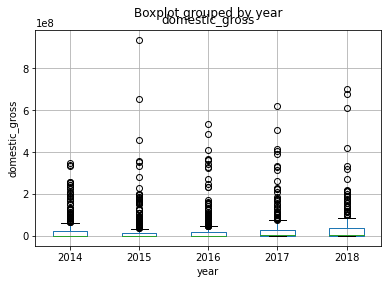

In [ ]:
# plot the outliers for domestic_gross and year using a box plot
plt.figure(figsize=(12, 6))
box_office_mojo_df.boxplot(column='domestic_gross', by='year')
plt.ylabel('domestic_gross')
plt.show()

As you can see from the data that there are a lot outliers in the data, which we will remove using the IQR methods "find_outliers" and "remove_outliers"

In [ ]:
# find the outliers
find_outliers(box_office_mojo_df, 'domestic_gross')

,title,studio,domestic_gross,year
0,Transformers: Age of Extinction,Par.,245400000.0,2014
1,The Hobbit: The Battle of the Five Armies,WB (NL),255100000.0,2014
2,Guardians of the Galaxy,BV,333200000.0,2014
3,Maleficent,BV,241400000.0,2014
4,The Hunger Games: Mockingjay - Part 1,LGF,337100000.0,2014
...,...,...,...,...
1653,The House With A Clock In Its Walls,Uni.,68500000.0,2018
1654,Instant Family,Par.,67400000.0,2018
1656,Game Night,WB (NL),69200000.0,2018
1659,Night School (2018),Uni.,77300000.0,2018


In [ ]:
# remove the outliers
box_office_mojo_df = remove_outliers(box_office_mojo_df, 'domestic_gross')

In [ ]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 33 to 1909
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1665 non-null   object 
 1   studio          1665 non-null   object 
 2   domestic_gross  1665 non-null   float64
 3   year            1665 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 65.0+ KB


### Review:
As you can see we have removed the outliers as we don't want the data to be skewed.

After finding the outliers using the IQR method we removed the outliers, which resulted in 1665 rows of data in the box_office_mojo_df

### imdb_movies_df

In [ ]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
5,A Trouble in Dollars,2014,101,5.6,34,Comedy
6,A Quiet Inquisition,2014,65,7.7,6,"Documentary,Drama,History"
7,Jinn,2014,97,4.2,4271,"Fantasy,Horror,Thriller"
9,Cut Bank,2014,93,6.1,9611,"Crime,Drama,Thriller"
...,...,...,...,...,...,...
16608,OJ: Guilty in Vegas,2017,100,6.0,27,Documentary
16609,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16611,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16613,Hail Satan?,2019,95,6.8,628,Documentary


<Figure size 864x432 with 0 Axes>

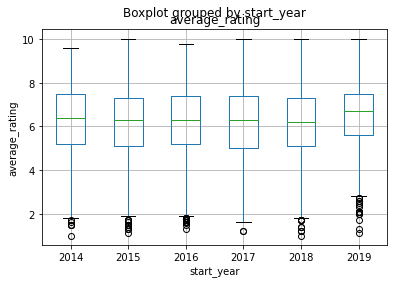

In [2738]:
# plot the outliers for average_rating and primary_title using a box plot
plt.figure(figsize=(12, 6))
imdb_movies_df.boxplot(column='average_rating', by='start_year')
plt.ylabel('average_rating')
plt.show()